### ResNet50 

ResNet의 네트워크 구조

<img src="pic/resnet50.png" width="600" height="300">

layer 50개 이상인 버전에서는 bottleneck skip connection 사용

<img src="pic/bottleneck.png">

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

c:\Users\root\anaconda3\envs\detectron_rev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model

In [5]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [7]:
def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)

In [9]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [10]:
#Dataset
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


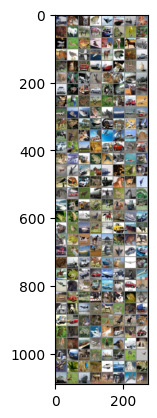

truck dog   dog   frog  plane ship  ship  dog   bird  dog   horse horse car   cat   bird  deer  plane deer  frog  bird  deer  bird  horse truck horse bird  plane plane horse frog  frog  car   frog  dog   car   truck ship  frog  deer  ship  dog   frog  plane deer  cat   cat   car   plane car   frog  truck car   dog   truck car   truck cat   bird  frog  deer  deer  truck truck plane plane ship  ship  bird  horse ship  plane truck horse frog  plane plane car   ship  plane plane horse bird  dog   truck plane ship  ship  cat   car   bird  plane deer  truck car   frog  truck deer  plane truck frog  plane cat   ship  dog   plane plane car   horse ship  cat   bird  cat   bird  frog  car   bird  truck dog   deer  plane cat   truck deer  truck horse bird  deer  car   ship  bird  truck frog  horse horse truck deer  frog  frog  truck deer  horse bird  ship  car   truck bird  ship  horse plane car   ship  deer  deer  frog  cat   horse plane frog  frog  horse truck deer  ship  horse truck plane car 

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
from tqdm import tqdm

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

num_epoch = 10
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

#Train
loss_arr = []
accuracy_arr = []

for i in range(num_epoch):

    total_accuracy = 0.0

    for j,[image,label] in enumerate(tqdm(trainloader, desc=f'Epoch {i+1}/{num_epoch}')):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, y_)
        total_accuracy += batch_accuracy

    avg_accuracy = total_accuracy / len(trainloader)
    accuracy_arr.append(avg_accuracy)

    print(f'Epoch {i+1}/{num_epoch}, Loss: {loss}, Train Accuracy: {avg_accuracy * 100:.2f}%')
    loss_arr.append(loss.cpu().detach().numpy())

model_path = 'ResNet50.pth'

torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_arr,
    }, model_path)

Epoch 1/10: 100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


Epoch 1/10, Loss: 1.3699666261672974, Train Accuracy: 51.19%


Epoch 2/10: 100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


Epoch 2/10, Loss: 1.116795539855957, Train Accuracy: 52.37%


Epoch 3/10: 100%|██████████| 196/196 [00:55<00:00,  3.55it/s]


Epoch 3/10, Loss: 1.3631237745285034, Train Accuracy: 56.70%


Epoch 4/10: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]


Epoch 4/10, Loss: 1.483820915222168, Train Accuracy: 62.57%


Epoch 5/10: 100%|██████████| 196/196 [00:55<00:00,  3.55it/s]


Epoch 5/10, Loss: 0.9200112223625183, Train Accuracy: 65.35%


Epoch 6/10: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


Epoch 6/10, Loss: 0.6665002703666687, Train Accuracy: 73.34%


Epoch 7/10: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]


Epoch 7/10, Loss: 0.839922308921814, Train Accuracy: 77.63%


Epoch 8/10: 100%|██████████| 196/196 [00:54<00:00,  3.60it/s]


Epoch 8/10, Loss: 0.9429134130477905, Train Accuracy: 68.14%


Epoch 9/10: 100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


Epoch 9/10, Loss: 0.6477788686752319, Train Accuracy: 73.46%


Epoch 10/10: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


Epoch 10/10, Loss: 0.7463364005088806, Train Accuracy: 81.76%
Model's state_dict:


In [17]:
model_path = 'ResNet50.pth'

model = resnet50().to(device)

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

with torch.no_grad():
    for image, label in testloader:
        x = image.to(device)
        y_ = label.to(device)
        output = model(x)
        
        _, predicted = torch.max(output, 1)
        accuracy = (predicted == y_).sum().item() / len(y_)
        print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 71.09%
Test Accuracy: 66.41%
Test Accuracy: 73.83%
Test Accuracy: 75.78%
Test Accuracy: 72.27%
Test Accuracy: 69.53%
Test Accuracy: 68.36%
Test Accuracy: 70.31%
Test Accuracy: 67.97%
Test Accuracy: 70.31%
Test Accuracy: 70.31%
Test Accuracy: 71.88%
Test Accuracy: 71.88%
Test Accuracy: 68.75%
Test Accuracy: 71.88%
Test Accuracy: 70.31%
Test Accuracy: 73.83%
Test Accuracy: 73.83%
Test Accuracy: 69.92%
Test Accuracy: 70.70%
Test Accuracy: 70.70%
Test Accuracy: 71.09%
Test Accuracy: 72.66%
Test Accuracy: 69.53%
Test Accuracy: 74.61%
Test Accuracy: 75.00%
Test Accuracy: 73.05%
Test Accuracy: 69.14%
Test Accuracy: 75.00%
Test Accuracy: 73.05%
Test Accuracy: 72.27%
Test Accuracy: 69.53%
Test Accuracy: 74.61%
Test Accuracy: 68.75%
Test Accuracy: 73.05%
Test Accuracy: 73.05%
Test Accuracy: 66.80%
Test Accuracy: 74.22%
Test Accuracy: 64.06%
Test Accuracy: 62.50%
